# LIS DQN 画像入力
学習済みネットワークを使わずに画像をQNetworkの入力としている

In [1]:
# GYM
import sys
tmp_path = []
for it in sys.path:
    if not 'gym' in it:
        # print(it)
        tmp_path.append(it)
sys.path = tmp_path
sys.path.append('../..')

In [2]:
from __future__ import print_function
import copy
import os
import random
import collections
import numpy as np
import six.moves.cPickle as pickle

import gym
from PIL import Image

import chainer
from chainer import cuda, FunctionSet, Variable, optimizers
from chainer import links as L
import chainer.functions as F
from chainer.links import caffe

%matplotlib notebook
import matplotlib.pyplot as plt
# set display defaults
plt.rcParams['figure.figsize'] = (10, 10)        # large images
plt.rcParams['image.interpolation'] = 'nearest'  # don't interpolate: show square pixels
plt.rcParams['image.cmap'] = 'gray'  # use grayscale output rather than a (potentially misleading) color heatmap


# QNet

In [3]:
class QFunction(chainer.Chain):

    def __init__(self, n_actions):
        initializer = chainer.initializers.HeNormal()
        c1 = 32
        c2 = 64
        c3 = 64
        fc_unit = 256*2

        super(QFunction, self).__init__(
             # the size of the inputs to each layer will be inferred
            conv1=L.Convolution2D(4, c1, 8, stride=4, pad=0),
            conv2=L.Convolution2D(c1, c2, 4, stride=2, pad=0),
            conv3=L.Convolution2D(c2, c2, 4, stride=2, pad=0),
            conv4=L.Convolution2D(c2, c3, 3, stride=1, pad=0),
            fc1=L.Linear(6400, fc_unit, initialW=initializer),
            fc2=L.Linear(fc_unit, n_actions, initialW=initializer),
        )

    def __call__(self, x):
        x = x/255.
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = F.relu(self.fc1(h))
        y = self.fc2(h)        
        return y

In [4]:
def get_greedy_action(Q, obs):
    xp = Q.xp
    obs = xp.expand_dims(xp.asarray(obs, dtype=np.float32), 0)
    with chainer.no_backprop_mode():
        q = Q(obs).data[0]
    return int(xp.argmax(q))

In [5]:
def mean_clipped_loss(y, t):
    # Add an axis because F.huber_loss only accepts arrays with ndim >= 2
    y = F.expand_dims(y, axis=-1)
    t = F.expand_dims(t, axis=-1)
    return F.sum(F.huber_loss(y, t, 1.0)) / y.shape[0]

In [6]:
def update(Q, target_Q, opt, samples, gamma=0.99, target_type='dqn'): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)
    r = np.asarray([sample[2] for sample in samples], dtype=np.float32)
    done = np.asarray([sample[3] for sample in samples], dtype=np.float32)
    s_next = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]
        s_next[i] = samples[i][4]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)
    r = xp.asarray(r)
    done = xp.asarray(done)
    s_next = xp.asarray(s_next)
    
    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    # Target: r + gamma * max Q_b (s',b)
    with chainer.no_backprop_mode():
        if target_type == 'dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.max(target_Q(s_next), axis=1)
        elif target_type == 'double_dqn':
            t = xp.sign(r) + gamma * (1 - done) * F.select_item(
                target_Q(s_next), F.argmax(Q(s_next), axis=1))
        else:
            raise ValueError('Unsupported target_type: {}'.format(target_type))
    loss = mean_clipped_loss(y, t)
    Q.cleargrads()
    loss.backward()
    opt.update()

In [7]:
def meanQvalue(Q, samples): 
    xp = Q.xp
    s = np.ndarray(shape=(minibatch_size, STATE_LENGTH, FRAME_WIDTH, FRAME_HEIGHT), dtype=np.float32)
    a = np.asarray([sample[1] for sample in samples], dtype=np.int32)

    for i in xrange(minibatch_size):
        s[i] = samples[i][0]

    # to gpu if available
    s = xp.asarray(s)
    a = xp.asarray(a)

    # Prediction: Q(s,a)
    y = F.select_item(Q(s), a)
    mean_Q = (F.sum(y)/minibatch_size).data
    return mean_Q
  

# 入力画像をStateへ変換

In [8]:
STATE_LENGTH = 4  # Number of most recent frames to produce the input to the network
FRAME_WIDTH = 224  # Resized frame width
FRAME_HEIGHT = 224  # Resized frame height
import numpy as np
from skimage.color import rgb2gray
from skimage.transform import resize

class ObsProcesser:
    mean_file = 'ilsvrc_2012_mean.npy'
    mean_name, ext = os.path.splitext(mean_file)

    def __init__(self):
        self.state = None
            
    def init_state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        state = [processed_obs for _ in xrange(STATE_LENGTH)]
        self.state = np.stack(state, axis=0)
        
    def obs2state(self, obs):
        processed_obs = self._preprocess_observation(obs)
        self.state = np.concatenate((self.state[1:, :, :], processed_obs[np.newaxis]), axis=0)
        return self.state
    
    def _preprocess_observation(self, obs):
        img = np.array(obs["image"][0])
        preprossed = np.asarray(resize(rgb2gray(img), (FRAME_WIDTH, FRAME_HEIGHT))*255, dtype=np.uint8)
        return preprossed
    

# Lis_DQN

In [9]:
# Initialize variables
depth_image_dim = 224 * 224
M = 10000  # number of episodes
replay_start_size = 1000  # steps after which we start to update
steps_to_decay_epsilon = 100000  # steps to take to decay epsilon
min_epsilon = 0.1  # minimum value of epsilon
sync_interval = 5000  # interval of target sync
evaluation_interval = 100 # 何エピソードごとに評価するか
update_inverval = 1
minibatch_size = 32  # size of minibatch
update_inverval = 1
reward_scale = 1  # scale factor for rewards
gpu = 0  # gpu id (-1 to use cpu)
target_type = 'dqn'  # 'dqn' or 'double_dqn'
#NO_OP_MAX = 10 # maximum number of "do anything" actions at the start of an episode
save_model_inverval = 25000 # interval of save weights
save_folder = 'checkpoints_touch'
D = collections.deque(maxlen=10 ** 5)  # replay memory: original 10 ** 6

Rs = []  # past returns
average_Rs = []
eval_Rs = [] # evaluation Max reward
eval_steps = [] # evaluation Max
step = 0  # total steps taken
episode = 0

networkname = 'image_input'
log_file = os.path.join(save_folder,'reward_'+networkname+'.log')

In [10]:
# disable stderre
import os
import sys
f = open(os.devnull, 'w')
sys.stderr = f
# 開始の時間表示
from datetime import datetime
print(datetime.now().strftime("%Y/%m/%d %H:%M:%S"))
# save folder
if not os.path.isdir(save_folder):
    os.mkdir(save_folder)
# log file
with open(log_file, 'w') as the_file:
    the_file.write('cycle, episode_reward_sum \n')

2017/01/21 03:24:53


# Initialize

In [11]:
enable_controller = [0,1,2]
n_actions = len(enable_controller)
obs_processer = ObsProcesser()

In [12]:
# Initialize chainer models
Q = QFunction(n_actions)
if gpu >= 0:
    chainer.cuda.get_device(gpu).use()
    Q.to_gpu(gpu)
target_Q = copy.deepcopy(Q)
opt = optimizers.RMSpropGraves(lr=0.00025, alpha=0.95, momentum=0.95, eps=0.0001)
opt.setup(Q)

In [13]:
env_name = 'Lis-v2'
env = gym.make(env_name)
obs = env.reset()
obs_processer.init_state(obs)
state = obs_processer.state

# Show observation image

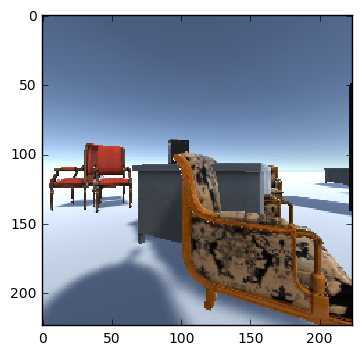

In [14]:
%matplotlib inline
plt.imshow(np.array(obs['image'][0]))

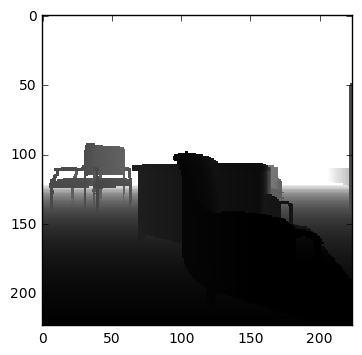

In [15]:
plt.imshow(obs['depth'][0])

# Evaluation

In [16]:
def Evaluation(epsilon = 0.05):
    Rs_eval = []  # past returns
    for episode in range(3):

        obs = env.reset()
        obs_processer.init_state(obs)

#         for _ in range(random.randint(1, NO_OP_MAX)):
#             a = env.action_space.sample()
#             obs, _, _, _ = env.step(a)  # Do anything
#             obs_processer.obs2state(obs)
            
        done = False
        R = 0.0
        state = obs_processer.state   

        while not done:
            # Select an action
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                a = get_greedy_action(Q, state)

            # Execute an action
            new_obs, r, done, _ = env.step(a)

            new_state = obs_processer.obs2state(new_obs)
            R += r
            state = new_state           

        print('Evaluation : episode: {} step: {} R:{}'.format(episode, step, R))
        Rs_eval.append(R)
    return Rs_eval

# Run

<IPython.core.display.Javascript object>


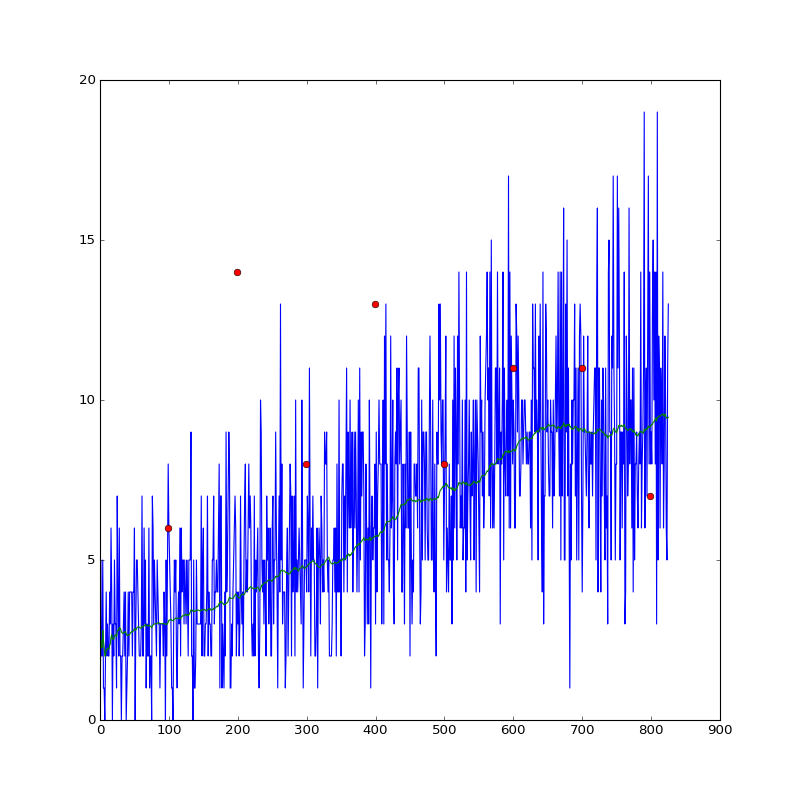

episode: 0 step: 157 R:0.0 average_R:0.0
episode: 10 step: 1727 R:2.0 average_R:2.18181818182
episode: 20 step: 3297 R:2.0 average_R:2.52380952381
episode: 30 step: 4867 R:2.0 average_R:2.83870967742
target Q update! mean Q value : 0.479326784611, epsilon:0.964
episode: 40 step: 6437 R:2.0 average_R:2.63414634146
episode: 50 step: 8007 R:6.0 average_R:2.86274509804
episode: 60 step: 9577 R:3.0 average_R:2.86885245902
target Q update! mean Q value : 0.524050951004, epsilon:0.919
episode: 70 step: 11147 R:2.0 average_R:2.92957746479
episode: 80 step: 12717 R:4.0 average_R:3.01234567901
episode: 90 step: 14287 R:3.0 average_R:3.01098901099
target Q update! mean Q value : 0.579433381557, epsilon:0.874
Evaluation : episode: 0 step: 15700 R:6.0
Evaluation : episode: 1 step: 15700 R:1.0
Evaluation : episode: 2 step: 15700 R:3.0
episode: 100 step: 15857 R:6.0 average_R:3.12
episode: 110 step: 17427 R:5.0 average_R:3.19
episode: 120 step: 18997 R:5.0 average_R:3.26
target Q update! mean Q value

WebSocketConnectionClosedException: Connection is already closed.

In [17]:
# Initialize a figure
%matplotlib notebook
fig, ax = plt.subplots(1,1)

while episode < M:
    obs = env.reset()
    obs_processer.init_state(obs)

#     for _ in range(random.randint(1, NO_OP_MAX)):
#         a = env.action_space.sample()
#         obs, _, _, _ = env.step(a)  # Do anything
#         obs_processer.obs2state(obs)
    done = False
    R = 0.0
    state = obs_processer.state   
    
    while not done:

        # Select an action
        epsilon = 1.0 if len(D) < replay_start_size else \
            max(min_epsilon, np.interp(
                step, [replay_start_size, replay_start_size+steps_to_decay_epsilon], [1.0, min_epsilon]))
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, info = env.step(a)

        new_state = obs_processer.obs2state(new_obs)

        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state

        # Sample a random minibatch of transitions
        if len(D) >= replay_start_size:
            if step % update_inverval == 0:
                samples = random.sample(D, minibatch_size)
                update(Q, target_Q, opt, samples, target_type=target_type)

            if step % sync_interval == 0:
                mean_Q = meanQvalue(Q, samples)
                target_Q = copy.deepcopy(Q)
                print('target Q update! mean Q value : {}, epsilon:{}'.format(mean_Q, epsilon))

            if step % save_model_inverval == 0:
                save_model_filename = "lis_dqn_{}_{}.h5".format(env_name, step)
                save_model_path = os.path.join(save_folder, save_model_filename)
                print('save model : {}'.format(save_model_path))
                chainer.serializers.save_hdf5(save_model_path, Q)

        step += 1

    with open(log_file, 'a') as the_file:
        the_file.write(str(episode) + ',' + str(R) + '\n')

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    average_Rs.append(average_R)
    if episode % 10 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))

    # evaluation
    if (episode+1) % evaluation_interval == 0:
        R_eval = Evaluation()
        eval_Rs.append(max(R_eval))
        eval_steps.append(episode)

                
    ax.clear()
    ax.plot(Rs)
    ax.plot(average_Rs)
    ax.plot(eval_steps, eval_Rs, "o")
    fig.canvas.draw()
    episode += 1
    
env.close()

In [20]:
env_name = 'Lis-v2'
env = gym.make(env_name)
obs = env.reset()
obs_processer.init_state(obs)
state = obs_processer.state

<IPython.core.display.Javascript object>


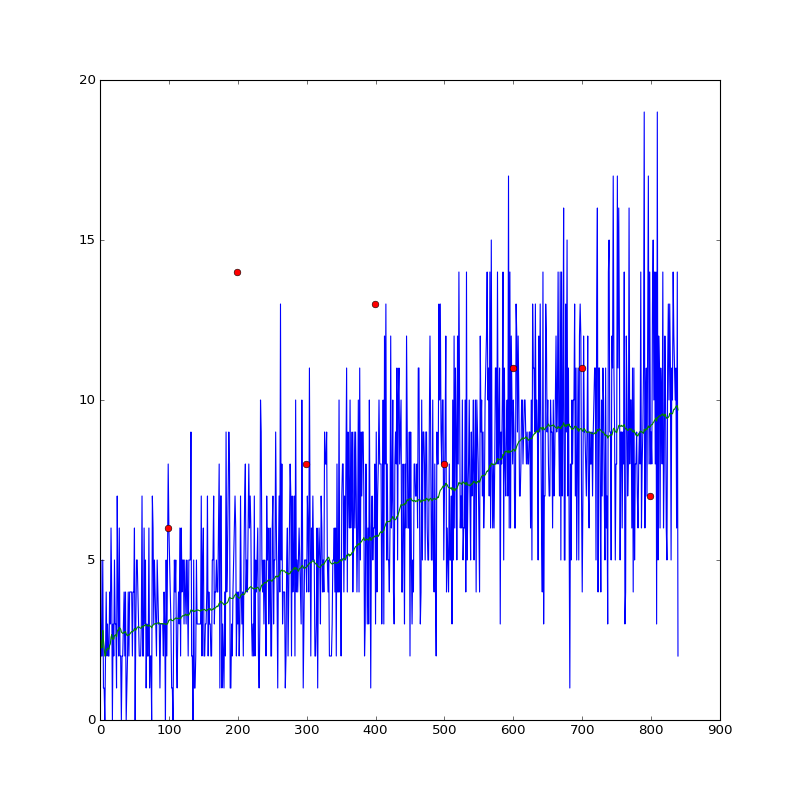

episode: 830 step: 130582 R:11.0 average_R:9.57


WebSocketConnectionClosedException: Connection is already closed.

In [21]:
# Initialize a figure
%matplotlib notebook
fig, ax = plt.subplots(1,1)

while episode < M:
    obs = env.reset()
    obs_processer.init_state(obs)

#     for _ in range(random.randint(1, NO_OP_MAX)):
#         a = env.action_space.sample()
#         obs, _, _, _ = env.step(a)  # Do anything
#         obs_processer.obs2state(obs)
    done = False
    R = 0.0
    state = obs_processer.state   
    
    while not done:

        # Select an action
        epsilon = 0.05
        if np.random.rand() < epsilon:
            a = env.action_space.sample()
        else:
            a = get_greedy_action(Q, state)

        # Execute an action
        new_obs, r, done, info = env.step(a)

        new_state = obs_processer.obs2state(new_obs)

        R += r

        # Store a transition
        D.append((state, a, r * reward_scale, done, new_state))
        state = new_state


        step += 1

    with open(log_file, 'a') as the_file:
        the_file.write(str(episode) + ',' + str(R) + '\n')

    Rs.append(R)
    average_R = np.mean(Rs[-100:])
    average_Rs.append(average_R)
    if episode % 10 is 0:
        print('episode: {} step: {} R:{} average_R:{}'.format(
              episode, step, R, average_R))

    # evaluation
    if (episode+1) % evaluation_interval == 0:
        R_eval = Evaluation()
        eval_Rs.append(max(R_eval))
        eval_steps.append(episode)

                
    ax.clear()
    ax.plot(Rs)
    ax.plot(average_Rs)
    ax.plot(eval_steps, eval_Rs, "o")
    fig.canvas.draw()
    episode += 1
    
env.close()